# 0. Introduction

In this analysis, we ask the following question: how can we use available OD data to target certain areas of the city for metro adoption? This is one way of defining the 'urban planner's dream' scenario, in which we can control who adopts based on a centrally-defined optimality criterion. 

## 0.1 Assumptions

- For a given origin-destination pair, traffic follows a single, shortest-path route.
- Congested travel times are computed by ITA, using the standard BPR function. 
- In the mathematical approximation below, $j_{od}$ is sufficiently small compared to $j_e$ that the linear approximation is reasonable. 

# 1. Mathematical Methods

In this section, we introduce the mathematical methods implemented by this analysis. 

##  1.1 Congestion gradient

As a formal version of our question: given a collection of OD pairs with flows between them $j_{od}$, how can we identify the pairs that most contribute to overall network congestion? And what would be the benefit of routing travellers between those pairs through public transportation, such as metro or buses? In this section, we present a mathematical approximation for answering these questions. 

Let $t_f(e)$ be the free-flow travel time along an edge $e$, and let $t_c(e)$ be the congested travel time. Suppose that $t_c(e)$ is related to $t_f(e)$ by the formula 

$$ t_c(e) = f(e) t_f(e)\;,$$

where $f(e)$ is a function that depends only on $e$. Define the time-excess due to congestion as 

$$ 
\begin{align}
    \tau(e) &= t_c(e) - t_f(e) \\
    &= (f(e) - 1) t_f(e)
\end{align}
$$

We'd like to reduce, not just the time-excess on a given edge, but the amount of time spent by drivers in congestion. An edge with high congestion but relatively little use (e.g. due to very low capacity) is less important to handle. So, if $j_e$ is the flow through $e$, we define the *(person-minutes of) congestion experienced* as $m(e) = j_e \tau (e)$$.

Suppose now that the congestion multiplier $f(e)$ is a function of $j_e$, so that we can write $f(e) = f(j_e)$. Then, the formula for $m_e$ becomes $m(j_e) = (f(j_e) - 1)j_e t_f(e)$. Our formal question now becomes: what is the effect of reducing flow on edge $e$ on $m(j_e)$? We can estimate the impact of reducing flow by one unit by computing $\frac{\partial m}{\partial j_e}$.

Let an origin node $o$ and a destination node $d$ be fixed, and let $j_{od}$ be the flow between them. Let $p$ be the shortest path between them, and assume that all of $j_{od}$ flows along $p$. Then, at any $e \in p$, the approximate reduction in congestion experienced of removing $j_{od}$ units of flow is 

$$ - j_{od} \frac{\partial m}{\partial j_e} \;,$$

and the total reduction in congestion experienced by removing $j_{od}$ units of flow along the whole path is 

$$ - j_{od} \sum_{e \in p} \frac{\partial m}{\partial j_e}$$

We'll call the sum the *congestion gradient* for the pair $o$ and $d$ -- it is the approximate effect on congestion experienced of removing one unit of flow between $o$ and $d$. Multiplying the gradient by $-j_{od}$ gives the estimate *congestion impact* of the pair $o$ and $d$, the route's total contribution to congestion experienced in the city. We'll write the gradient as $\nabla_{od}$. 

## 1.2 BPR Simplification

In case $f(j_e)$ has a simple form, we can compute the congestion gradient in a tractable way. Suppose that $f$ is given by the BPR function $f(j_e) = 1 + a \left(\frac{j_e}{c_e}\right)^b$, where $c_e$ is the capacity of the edge and $a$ and $b$ are constants. Then, the formula for $m(e)$ simplifies to $m(e) = \left(a\frac{j_e^{b+1}}{c_e^b}\right) t_f(e)$, and 

$$\partial m / \partial j_e = a b t_f(e) \left(\frac{j_e}{c_e}\right)^b  = b\left(f(j_e) - 1\right)\;,$$

yielding a formula for the congestion gradient as 

$$ \nabla_{od} = \sum_{e \in p} \frac{\partial m}{\partial j_e} = ab  \sum_{e \in p} t_f(e) \left(\frac{j_e}{c_e}\right)^b $$.   

## 1.3 Other Quantities

We also consider the *supply-demand ratio* for fixed $o$ and $d$, denote $r_{od}$, computed as 

$$ r_{od} = \frac{\sum_{e \in p} \ell_e j_e}{\sum_{e \in p} \ell_e c_e}\;, $$

it measures the ratio of cars travelling on a route to the lane-space available to hold them. As we'll see, $r_{od}$ is closely correlated with the congestion gradient. 

In [1]:
# Get setup

% matplotlib inline 
#plots in the doc

# homebrewed modules
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import matplotlib.pyplot as plt # convenience for plotting
import seaborn as sns           # main plotting library
from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import pandas as pd

# preferences across the worksheet
warnings.filterwarnings('ignore') # stops ipython from printing warnings
sns.set_style("white") # nicer background style


In [2]:
# read in necessary data
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/
G = multi.layers_as_subgraph(['taz', 'streets'])
g = utility.nx_2_igraph(G)
od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt')

# 2. High-Level Analysis

In the first part of our analysis, we compute the congestion gradient and supply-demand ratio for all OD pairs across Riyadh. We then consider how these quantities are related to each other, and how they are distributed spatially around the city. 

In [3]:
# define congestion_gradient 

def congestion_gradient(free_flow_time_m, flow, capacity, a = .15, b = 4): # based on BPR function
    return free_flow_time_m * a * b * (flow / capacity) ** b

In [4]:
# define a traffic summary: 

def traffic_summary(g, od, weight, flow):
    from collections import defaultdict
    df = defaultdict(int)
    
    di = {e.index : (g.es[e.index]['layer'],
                g.es[e.index]['capacity'],
                g.es[e.index][flow], 
                float(g.es[e.index]['free_flow_time_m']),
                float(g.es[e.index][weight]),
                float(g.es[e.index]['dist_km'])) 
         for e in g.es}

    o = []
    d = []
    flow = []
    traffic = []
    capacity = []
    free_flow_time_m = []
    congested_time_m = []
    dist_km = []
    gradient = []
    
    for origin in od:
        ds = od[origin]
        if len(ds) > 0: 
            targets = ds.keys()
            paths = g.get_shortest_paths(origin,
                                        to = targets,
                                        weights = weight,
                                        mode = 'OUT',
                                        output = 'epath')
            for i in range(len(targets)):
                street_path = [e for e in paths[i] if di[e][0] == 'streets']
                metro_path = [e for e in paths[i] if di[e][0] == 'metro']
                
                o += [origin]
                d += [targets[i]]
                flow += [od[origin][targets[i]]]
                traffic += [np.sum([di[e][2]*di[e][5] for e in street_path])]
                capacity += [np.sum([di[e][1]*di[e][5] for e in street_path])]
                free_flow_time_m += [np.sum([di[e][3] for e in street_path])]
                congested_time_m += [np.sum([di[e][4] for e in street_path])]
                dist_km += [np.sum([di[e][5] for e in street_path])]
                gradient += [np.sum([congestion_gradient(di[e][3], di[e][2], di[e][1]) 
                                            for e in street_path])]
    
    df = pd.DataFrame({'o' : np.array(o), 
                       'd' : np.array(d), 
                       'traffic' : np.array(traffic),
                       'capacity' : np.array(capacity),
                       'free_flow_time_m' : np.array(free_flow_time_m),
                       weight : np.array(congested_time_m),
                       'dist_km' : np.array(dist_km),
                       'flow' : np.array(flow),
                       'gradient' : np.array(gradient)})
    
    df = df[df['capacity'] != 0]
    
    df['ratio'] = df['traffic']/df['capacity']
    df['time_lost'] = df[weight]/df['free_flow_time_m']
    df['mean_speed'] = df['dist_km'] / df[weight]*60
    df['congestion_impact'] = df['gradient'] * df['flow']
    
    return df

In [5]:
sub_od = {key : od[key] for key in od.keys()[:]}
df = traffic_summary(g, sub_od, weight = 'congested_time_m', flow = 'flow')

In [6]:
cols = ['o', 'd', 'dist_km', 'congestion_impact', 'gradient', 'flow','ratio', 'time_lost', 'congested_time_m']
df = df[cols].sort_values('gradient', ascending = False)

We compute the congestion impact, $\nabla_{od}$, and $r_{od}$ for each OD pair. We also show distance (km) along the route, congested time along the route, flow along the route (as specified by the OD matrix) for context. 

### Summary Statistics

In [7]:
cols = ['dist_km', 'congested_time_m', 'flow', 'congestion_impact', 'gradient','ratio']
np.round(df[cols].describe(),2)

,dist_km,congested_time_m,flow,congestion_impact,gradient,ratio
count,4520228.00,4520228.00,4520228.00,4520228.00,4520228.00,4520228.00
mean,18.62,25.33,0.51,3.61,9.23,0.62
std,12.00,13.30,2.87,35.34,9.64,0.25
min,0.02,0.03,0.00,0.00,0.00,0.00
25%,9.66,15.31,0.04,0.16,2.51,0.44
50%,16.47,23.93,0.12,0.65,6.33,0.61
75%,24.89,33.59,0.37,2.33,12.77,0.78
max,118.95,115.38,1331.31,16094.45,123.23,2.98


### Distribution of $\nabla_{od}$

What is the distribution of $\nabla_{od}$ across the city? Below, we plot the distribution weighted by flow. The result of the weighting is that the distribution now measures the gradient of individuals. 

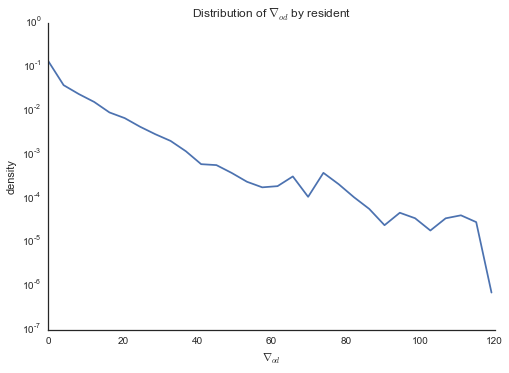

In [8]:
n = 30
hist = np.histogram(df['gradient'], weights = df['flow'], normed = True, bins = n)
x = hist[1][:n] 
y = hist[0]

plt.semilogy(x,y)
plt.gca().set(xlabel = r'$\nabla_{od}$', ylabel = 'density', title = r'Distribution of $\nabla_{od}$ by resident')
# plt.loglog(x,y)
sns.despine()

The distribution is approximately linear on semilog axes, suggesting that the distribution itself is approximately exponential. However, there is a lot of noise in the tail, so conclusions are hard to draw. The average gradient per individual is:

In [9]:
round(np.average(df['gradient'], weights = df['flow']),1)

7.1

On average, rerouting a person through public transportation saves 7 minutes of overall congestion experienced throughout the city. However, there are a small number of individuals for whom rerouting them would have much higher impact, on the order of 1-2 hours. 

### Relationship of $\nabla_{od}$ to other measures

In general, we would expect the congestion gradient to be closely linked with other measures related to congestion. Below, we plot $\nabla_{od}$ against the product of the supply-demand ratio ($r_{od}$) and congested time ($t_c$). The motivation for this is that we would expect the gradient of an OD pair to be dependent on both mean congestion along the route (measured by the supply-demand ratio) and the time spent on the route (measured by congested time). 

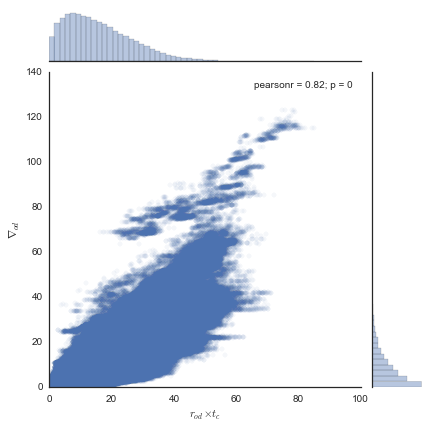

In [10]:
fig = sns.jointplot(y = df['gradient'], x = df['ratio']*df['congested_time_m'], alpha = 0.05)
fig.ax_joint.set(xlabel = r'$r_{od} \times t_c$', ylabel = r'$\nabla_{od}$', xlim = (0,None), ylim = (0,None))
plt.show()

We observe a high correlation between the two measures, as expected. More intriguingly, we also observe the existence of a small number OD pairs with much higher $\nabla_{od}$ than would be predicted by this simple model. This suggests that a campaign of targeting a small number of routes could have potentially high payoff for reducing congestion. 

### Spatial Distribution of $\nabla_{od}$

How is $\nabla_{od}$ distributed throughout the city? Generally speaking, we would expect that origins in crowded residential areas would have high $\nabla_{od}$, as would destinations in downtown areas. In the visualization below, we plot mean $\nabla_{od}$, first aggregated by origin, and then aggregated by destination. Warmer colors reflect higher $\nabla_{od}$, while larger bubbles reflect higher flow from/to that node. 

In [11]:
def wavg_constructor(col, weight):
    def wavg(group):
        d = group[col]
        w = group[weight]
        return (d * w).sum() / w.sum()
    return wavg

In [12]:
# computed weighted averages and add them to multi.G

wavg = wavg_constructor('gradient', 'flow')
x = df.groupby('o').apply(wavg)
y = df.groupby('o').sum()['flow']
nx_keys = {v.index : v['name'] for v in g.vs}
d = pd.DataFrame({'gradient' : x, 'demand' : y})

d['node'] = d.index.map(nx_keys.get)
d = d.set_index('node')
d = d.to_dict()

nx.set_node_attributes(multi.G, 'o_gradient', 0)
nx.set_node_attributes(multi.G, 'o_gradient', d['gradient'])

nx.set_node_attributes(multi.G, 'o_demand', 0)
nx.set_node_attributes(multi.G, 'o_demand', d['demand'])

# -------
# same analysis for demand
wavg = wavg_constructor('gradient', 'flow')
x = df.groupby('d').apply(wavg)
y = df.groupby('d').sum()['flow']
nx_keys = {v.index : v['name'] for v in g.vs}
d = pd.DataFrame({'gradient' : x, 'demand' : y})

d['node'] = d.index.map(nx_keys.get)
d = d.set_index('node')
d = d.to_dict()

nx.set_node_attributes(multi.G, 'd_gradient', 0)
nx.set_node_attributes(multi.G, 'd_gradient', d['gradient'])

nx.set_node_attributes(multi.G, 'd_demand', 0)
nx.set_node_attributes(multi.G, 'd_demand', d['demand'])

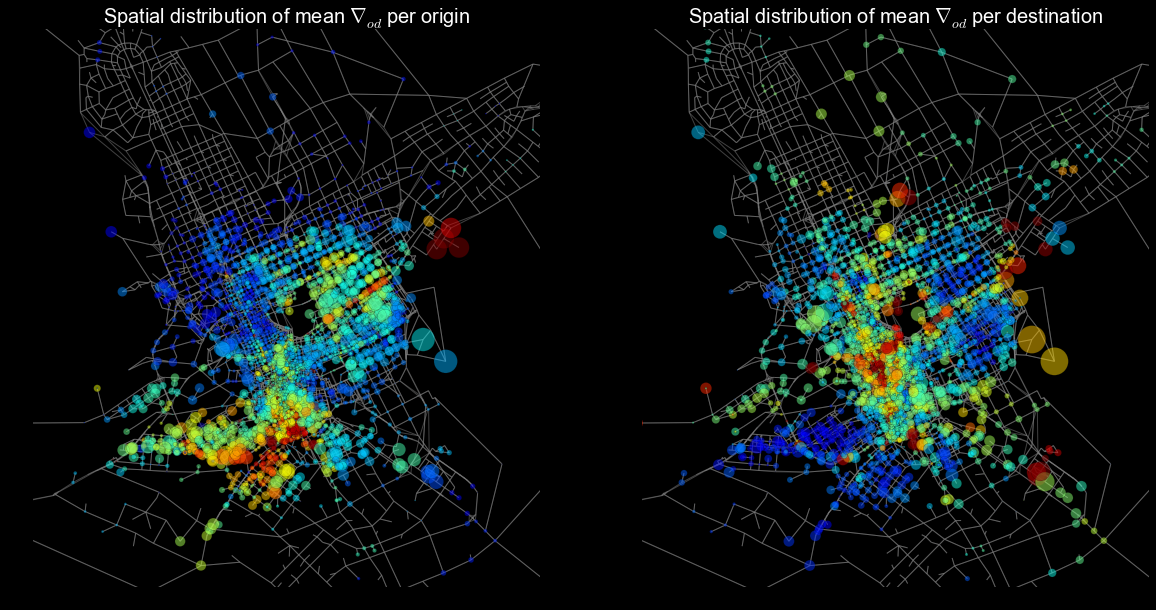

In [13]:
# create the plot

G = multi.G # pull G for plotting functions

# create the figure

xlim = (46.4167, 47.0167)
ylim = (24.4333, 25.0333)
fig = plt.figure(figsize = (2*10,10), dpi = 500)

ax = fig.add_subplot(121)
viz.bubble_plot(G, size = 'o_demand', color = 'o_gradient' , size_factor = 0.05, vmax = 15, cmap = 'jet', alpha = .5)
ax.set(xlim = xlim, ylim = ylim)
plt.title(r'Spatial distribution of mean $\nabla_{od}$ per origin', 
              color = 'w', 
              fontsize = 20)

ax = fig.add_subplot(122)
viz.bubble_plot(G, size = 'd_demand', color = 'd_gradient' , size_factor = 0.05, vmax = 15, cmap = 'jet', alpha = .5)
ax.set(xlim = xlim, ylim = ylim)
plt.title(r'Spatial distribution of mean $\nabla_{od}$ per destination', 
              color = 'w', 
              fontsize = 20)

fig.set_facecolor("#000000")

We can read these plots as follows: on the left, an individual who lives near a red bubble is likely to have high $\nabla_{od}$, and therefore have a high contribution to overall congestion. Similarly on the right, an individual who works near a red bubble is likely to have high $\nabla_{od}$. 

On the left, we observe pockets of high $\nabla_{od}$ in the southwest and northeast of the city, suggesting crowded residential neighborhoods with high travel demand downtown. On the right, correspondingly, we observe high $\nabla_{od}$ in the center of the city. 

On a practical level, these plots suggest that public transportation (buses or metro) going *from* highlighted areas on the left *to* highlighted areas on the right would be efficient at reducing overall congestion. 

# 3. Targeting Routes

We can also consider more detail in targeting routes and areas for adoption of public transportation. We can assemble an outline of high-priority routes as follows. First, we rank OD pairs by $j_{od}\nabla_{od}$, so that pairs with high rank have high impact on congestion. We then find routes for each of these pairs, adding $j_{od}$ units of flow to each edge on the route. The resulting network of edges with positive flow totals then approximates a public transportation network serving routes contributing the most to urban congestion.  

We plot such a network below for the top 10000 OD pairs. Only edges with total flow greater than 500 cars/hour are shown. Note that, due to 'targeting' high priority routes, the proportion of congestion reduced is significantly greater than the percentage of flow routed through the public transportation system. Darker edges correspond to routes with higher traffic, therefore needing more service. 

In [63]:
df = df.sort_values('congestion_impact', ascending = False)

In [65]:
n = 10000

from collections import defaultdict
e_dict = defaultdict(int)

for o,d,flow in zip(df[:n].o, df[:n].d, df[:n].flow):
    path = g.get_shortest_paths(o,
                                to = d,
                                weights = 'congested_time_m',
                                mode = 'OUT',
                                output = 'epath')
    for e in path[0]:
        e_dict[e] += flow
        
e_dict = {(g.es[e].source, g.es[e].target) : e_dict[e] for e in e_dict.keys()}
e_dict = {(nx_keys[e[0]], nx_keys[e[1]]) : e_dict[e] for e in e_dict}

nx.set_edge_attributes(multi.G, 'flow', 0)
nx.set_edge_attributes(multi.G, 'flow', e_dict)

In [87]:
import copy
H = copy.deepcopy(G)
for e in copy.deepcopy(H).edges_iter():
    if H.edge[e[0]][e[1]]['flow'] < 500:
        H.remove_edge(e[0],e[1])

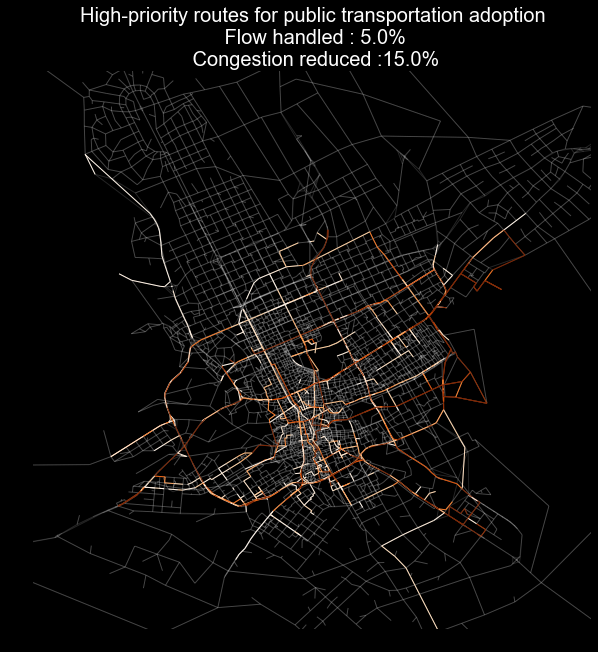

In [88]:
G = multi.G

fig = plt.figure(dpi = 500, figsize = (10,10))
ax = fig.add_subplot(111)

from matplotlib import pyplot as plt

nx.draw(G, G.position,
       edge_color = 'white',
       arrows = False,
       edge_size = 10,
       ax = ax,
       node_size = 0,
       alpha = .15)

H.position = {n : (H.node[n]['lon'], H.node[n]['lat']) for n in H}
H.colors = [H.edge[e[0]][e[1]]['flow'] for e in H.edges_iter()]

nx.draw_networkx_edges(H, H.position, 
           edge_color=H.colors, 
           arrows = False,
           edge_size = 100,
           edge_cmap = plt.get_cmap('Oranges'),
           ax = ax,
           node_size = 0,
           edge_vmin = 500, 
           edge_vmax = 2000,
           alpha = 1)

x = sum(df[:n]['congestion_impact'])/sum(df['congestion_impact'])
y = sum(df[:n]['flow'])/sum(df['flow'])

trim_ratio = sum([H.edge[e[0]][e[1]]['flow'] for e in H.edges_iter()]) / sum([G.edge[e[0]][e[1]]['flow'] for e in G.edges_iter()])

x = x * trim_ratio

y = y * trim_ratio

plt.title('High-priority routes for public transportation adoption \n Flow handled : ' + str(round(y * 100,0)) + '%\n Congestion reduced :' + str(round(x * 100,0)) + '%', 
          color = 'w', 
          fontsize = 20)

ax.set(xlim = xlim, ylim = ylim)
fig.set_facecolor("#000000")

We can estimate the 'payoff' of congestion reduced per flow handled by following the curve plotted below. A point on this curve reflects the amount of congestion reduced for a fixed level of flow through public transportation, under the targeting scheme described above. The grey line is a benchmark reflecting no targeting. We see that, under this targeting scheme, routing 10% of carefully targeted flow through a public transportation system could lead to congestion reductions of over 20%. 

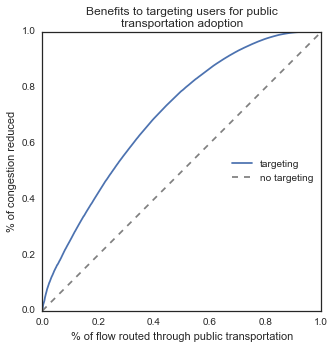

In [89]:
plt.figure(figsize = (5,5))
plt.plot(df.flow.cumsum() / sum(df.flow), df.congestion_impact.cumsum() / sum(df.congestion_impact), label = 'targeting')

plt.plot([0,1],[0,1], color = 'grey', linestyle = '--', label = 'no targeting')

plt.gca().set(xlabel = '% of flow routed through public transportation', 
             ylabel = '% of congestion reduced',
             title = 'Benefits to targeting users for public \ntransportation adoption')

plt.legend(loc = 'center right')
plt.show()

# Wrapping Up

We have explored a simple mathematical model for approximating the impact of OD pairs on congestion. Using this model, we have found that a relatively small number of travellers account for very high congestion impact, as measured by $\nabla_{od}$, suggesting significant opportunities for targeting adoption of public transportation. We then showed how a simple ranking scheme could generate realistic public transportation routes for serving these travellers. Under the "urban planner's dream" of centrally-planned public transportation adoption, these routes might reflect close-to-optimal bus lines with significant impact on urban congestion.  

Questions ahead: 

- This analysis is independent of the metro line. How does our key question change when we are thinking specifically of *metro* adoption?
- How does this "urban planner's dream" compare to other adoption scenarios, e.g. socially optimal routing, selfish routing, or demographic-based adoption? 
